<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#美国小麦" data-toc-modified-id="美国小麦-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>美国小麦</a></span><ul class="toc-item"><li><span><a href="#数据缺失值情况" data-toc-modified-id="数据缺失值情况-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>数据缺失值情况</a></span></li><li><span><a href="#处理缺失值" data-toc-modified-id="处理缺失值-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>处理缺失值</a></span></li><li><span><a href="#数据集的情况" data-toc-modified-id="数据集的情况-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>数据集的情况</a></span><ul class="toc-item"><li><span><a href="#特征列" data-toc-modified-id="特征列-1.3.1"><span class="toc-item-num">1.3.1&nbsp;&nbsp;</span>特征列</a></span></li><li><span><a href="#非重复值的数量" data-toc-modified-id="非重复值的数量-1.3.2"><span class="toc-item-num">1.3.2&nbsp;&nbsp;</span>非重复值的数量</a></span></li><li><span><a href="#两年相同位置有多少" data-toc-modified-id="两年相同位置有多少-1.3.3"><span class="toc-item-num">1.3.3&nbsp;&nbsp;</span>两年相同位置有多少</a></span></li></ul></li><li><span><a href="#两年数据的一致性" data-toc-modified-id="两年数据的一致性-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>两年数据的一致性</a></span></li><li><span><a href="#【周报6】部分县有多个产量数据" data-toc-modified-id="【周报6】部分县有多个产量数据-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>【周报6】部分县有多个产量数据</a></span></li><li><span><a href="#一个地方的数据是否持续了整个季" data-toc-modified-id="一个地方的数据是否持续了整个季-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>一个地方的数据是否持续了整个季</a></span><ul class="toc-item"><li><span><a href="#13年的异常" data-toc-modified-id="13年的异常-1.6.1"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>13年的异常</a></span></li><li><span><a href="#其他不足185天是什么情况" data-toc-modified-id="其他不足185天是什么情况-1.6.2"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>其他不足185天是什么情况</a></span></li></ul></li><li><span><a href="#找出不同位置小麦耕种的起始结束" data-toc-modified-id="找出不同位置小麦耕种的起始结束-1.7"><span class="toc-item-num">1.7&nbsp;&nbsp;</span>找出不同位置小麦耕种的起始结束</a></span><ul class="toc-item"><li><span><a href="#每个地点出现的频率" data-toc-modified-id="每个地点出现的频率-1.7.1"><span class="toc-item-num">1.7.1&nbsp;&nbsp;</span>每个地点出现的频率</a></span></li></ul></li><li><span><a href="#删除耕作周期过长或过短的数据" data-toc-modified-id="删除耕作周期过长或过短的数据-1.8"><span class="toc-item-num">1.8&nbsp;&nbsp;</span>删除耕作周期过长或过短的数据</a></span><ul class="toc-item"><li><span><a href="#两年数据位置对比" data-toc-modified-id="两年数据位置对比-1.8.1"><span class="toc-item-num">1.8.1&nbsp;&nbsp;</span>两年数据位置对比</a></span></li></ul></li><li><span><a href="#降水量" data-toc-modified-id="降水量-1.9"><span class="toc-item-num">1.9&nbsp;&nbsp;</span>降水量</a></span></li><li><span><a href="#相关性" data-toc-modified-id="相关性-1.10"><span class="toc-item-num">1.10&nbsp;&nbsp;</span>相关性</a></span><ul class="toc-item"><li><span><a href="#删除相关性过高的列" data-toc-modified-id="删除相关性过高的列-1.10.1"><span class="toc-item-num">1.10.1&nbsp;&nbsp;</span>删除相关性过高的列</a></span></li></ul></li><li><span><a href="#【周报7】地图可视化" data-toc-modified-id="【周报7】地图可视化-1.11"><span class="toc-item-num">1.11&nbsp;&nbsp;</span>【周报7】地图可视化</a></span></li><li><span><a href="#删掉预测无关的列" data-toc-modified-id="删掉预测无关的列-1.12"><span class="toc-item-num">1.12&nbsp;&nbsp;</span>删掉预测无关的列</a></span></li><li><span><a href="#散布矩阵" data-toc-modified-id="散布矩阵-1.13"><span class="toc-item-num">1.13&nbsp;&nbsp;</span>散布矩阵</a></span></li><li><span><a href="#训练-测试集划分" data-toc-modified-id="训练-测试集划分-1.14"><span class="toc-item-num">1.14&nbsp;&nbsp;</span>训练-测试集划分</a></span></li><li><span><a href="#数值标准化" data-toc-modified-id="数值标准化-1.15"><span class="toc-item-num">1.15&nbsp;&nbsp;</span>数值标准化</a></span></li><li><span><a href="#【周报8】回归模型测试性能" data-toc-modified-id="【周报8】回归模型测试性能-1.16"><span class="toc-item-num">1.16&nbsp;&nbsp;</span>【周报8】回归模型测试性能</a></span><ul class="toc-item"><li><span><a href="#算法性能总结" data-toc-modified-id="算法性能总结-1.16.1"><span class="toc-item-num">1.16.1&nbsp;&nbsp;</span>算法性能总结</a></span></li><li><span><a href="#线性回归" data-toc-modified-id="线性回归-1.16.2"><span class="toc-item-num">1.16.2&nbsp;&nbsp;</span>线性回归</a></span></li><li><span><a href="#L2正规化线性回归" data-toc-modified-id="L2正规化线性回归-1.16.3"><span class="toc-item-num">1.16.3&nbsp;&nbsp;</span>L2正规化线性回归</a></span></li><li><span><a href="#多项式回归" data-toc-modified-id="多项式回归-1.16.4"><span class="toc-item-num">1.16.4&nbsp;&nbsp;</span>多项式回归</a></span></li><li><span><a href="#正规化多项式回归" data-toc-modified-id="正规化多项式回归-1.16.5"><span class="toc-item-num">1.16.5&nbsp;&nbsp;</span>正规化多项式回归</a></span></li><li><span><a href="#随机森林回归" data-toc-modified-id="随机森林回归-1.16.6"><span class="toc-item-num">1.16.6&nbsp;&nbsp;</span>随机森林回归</a></span></li><li><span><a href="#Gradient-boost" data-toc-modified-id="Gradient-boost-1.16.7"><span class="toc-item-num">1.16.7&nbsp;&nbsp;</span>Gradient boost</a></span></li><li><span><a href="#KNN" data-toc-modified-id="KNN-1.16.8"><span class="toc-item-num">1.16.8&nbsp;&nbsp;</span>KNN</a></span></li><li><span><a href="#支持向量回归" data-toc-modified-id="支持向量回归-1.16.9"><span class="toc-item-num">1.16.9&nbsp;&nbsp;</span>支持向量回归</a></span><ul class="toc-item"><li><span><a href="#RBF-kernel" data-toc-modified-id="RBF-kernel-1.16.9.1"><span class="toc-item-num">1.16.9.1&nbsp;&nbsp;</span>RBF kernel</a></span></li><li><span><a href="#linear-kernel" data-toc-modified-id="linear-kernel-1.16.9.2"><span class="toc-item-num">1.16.9.2&nbsp;&nbsp;</span>linear kernel</a></span></li><li><span><a href="#polynomial-kernel" data-toc-modified-id="polynomial-kernel-1.16.9.3"><span class="toc-item-num">1.16.9.3&nbsp;&nbsp;</span>polynomial kernel</a></span></li></ul></li><li><span><a href="#KRR（脊核回归）" data-toc-modified-id="KRR（脊核回归）-1.16.10"><span class="toc-item-num">1.16.10&nbsp;&nbsp;</span>KRR（脊核回归）</a></span></li></ul></li><li><span><a href="#【周报9】进一步测试随机森林" data-toc-modified-id="【周报9】进一步测试随机森林-1.17"><span class="toc-item-num">1.17&nbsp;&nbsp;</span>【周报9】进一步测试随机森林</a></span><ul class="toc-item"><li><span><a href="#去掉位置信息，再次训练" data-toc-modified-id="去掉位置信息，再次训练-1.17.1"><span class="toc-item-num">1.17.1&nbsp;&nbsp;</span>去掉位置信息，再次训练</a></span></li></ul></li><li><span><a href="#绘制随机森林学习曲线" data-toc-modified-id="绘制随机森林学习曲线-1.18"><span class="toc-item-num">1.18&nbsp;&nbsp;</span>绘制随机森林学习曲线</a></span></li><li><span><a href="#【周报10】按位置分组" data-toc-modified-id="【周报10】按位置分组-1.19"><span class="toc-item-num">1.19&nbsp;&nbsp;</span>【周报10】按位置分组</a></span></li><li><span><a href="#聚合后再训练" data-toc-modified-id="聚合后再训练-1.20"><span class="toc-item-num">1.20&nbsp;&nbsp;</span>聚合后再训练</a></span></li></ul></li></ul></div>

In [1]:
import pandas as pd
import time
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# 美国小麦

In [2]:
wheat13 = pd.read_csv('./data/wheat-2013-supervised.csv')
wheat14 = pd.read_csv('./data/wheat-2014-supervised.csv')

In [3]:
wheat13.head()

,CountyName,State,Latitude,Longitude,Date,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,...,precipTypeIsOther,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield
0,Adams,Washington,46.811686,-118.695237,11/30/2013 0:00,35.70,20.85,0.00,29.53,0.91,...,0,1027.13,35.70,27.48,2.46,214,1.18,134.110657,0,35.7
1,Adams,Washington,46.929839,-118.352109,11/30/2013 0:00,35.10,26.92,0.00,29.77,0.93,...,0,1026.87,35.10,26.92,2.83,166,1.01,131.506592,0,35.7
2,Adams,Washington,47.006888,-118.510160,11/30/2013 0:00,33.38,26.95,0.00,29.36,0.94,...,0,1026.88,33.38,26.95,2.95,158,1.03,131.472946,0,35.7
3,Adams,Washington,47.162342,-118.699677,11/30/2013 0:00,28.05,25.93,0.91,29.47,0.94,...,0,1026.37,33.19,27.17,2.89,153,1.84,131.288300,0,35.7
4,Adams,Washington,47.157512,-118.434056,11/30/2013 0:00,28.83,25.98,0.91,29.86,0.94,...,0,1026.19,33.85,27.07,2.97,156,1.85,131.288300,0,35.7


In [4]:
wheat13.Yield.is_unique

False

## 数据缺失值情况

In [46]:
[wheat13.shape, wheat14.shape]

[(177493, 26), (182549, 26)]

In [47]:
wheat13.CountyName.value_counts()

Garfield     3348
Grant        3348
Ellis        3326
Comanche     2232
Clay         2232
             ... 
Delaware      186
Coal          186
Jim Wells     186
Johnston       25
Lamar           7
Name: CountyName, Length: 150, dtype: int64

In [48]:
wheat13.isnull().sum()

CountyName                  0
State                       0
Latitude                    0
Longitude                   0
Date                        0
apparentTemperatureMax      0
apparentTemperatureMin      0
cloudCover                  0
dewPoint                    0
humidity                    0
precipIntensity             1
precipIntensityMax          1
precipProbability           1
precipAccumulation          0
precipTypeIsRain            0
precipTypeIsSnow            0
precipTypeIsOther           0
pressure                  254
temperatureMax              0
temperatureMin              0
visibility                 30
windBearing                 0
windSpeed                   0
NDVI                        0
DayInSeason                 0
Yield                       0
dtype: int64

In [49]:
wheat14.isnull().sum()

CountyName                  0
State                       0
Latitude                    0
Longitude                   0
Date                        0
apparentTemperatureMax      0
apparentTemperatureMin      0
cloudCover                  0
dewPoint                    0
humidity                    0
precipIntensity             0
precipIntensityMax          0
precipProbability           0
precipAccumulation          0
precipTypeIsRain            0
precipTypeIsSnow            0
precipTypeIsOther           0
pressure                  351
temperatureMax              0
temperatureMin              0
visibility                 16
windBearing                 0
windSpeed                   0
NDVI                        0
DayInSeason                 0
Yield                       0
dtype: int64

## 处理缺失值

In [5]:
def impute_with_nearest(in_df,in_column):
    """
    将缺失值填充为同一天位置最近的值
    """
    # 缺失值位置  
    df_nan = in_df[in_df[in_column].isnull()]
    if len(df_nan) > 0:
        # 找同一天，位置相近
        for i in range(len(df_nan)):
            tmp_date = df_nan['Date'].iloc[i]
            tmp_long = df_nan['Longitude'].iloc[i]
            tmp_lat  = df_nan['Latitude'].iloc[i]
            tmp_index = df_nan['Latitude'].index.tolist()[i]
            condition = (((in_df['Latitude'] != tmp_lat) |
                         (in_df['Longitude'] != tmp_long)) & 
                         (in_df['Date'] == tmp_date) & 
                         (in_df[in_column].notnull())) 
            # 按距离排序
            new_df = in_df[['Longitude', 'Latitude']][condition]
            new_df['Distance'] = new_df['Longitude']
            for j in range(len(new_df)):
                new_df['Distance'].iloc[j] = haversine(tmp_long,
                                                       tmp_lat,
                                                       new_df['Longitude'].iloc[j],
                                                       new_df['Latitude'].iloc[j])
            # 选取同一天的最近位置
            tmp_df = new_df.sort_values(by='Distance', ascending=True)
            tmp_min_dist = tmp_df.iloc[0,2]
            tmp_min_index = tmp_df.index.tolist()[0]
            # 替换缺失值
            old_val = in_df[in_column].iloc[tmp_index]
            new_val = in_df[in_column].iloc[tmp_min_index]
            in_df[in_column].iloc[tmp_index] = new_val

In [6]:
from math import radians, cos, sin, asin, sqrt

def haversine(lon1, lat1, lon2, lat2):
    """
    经纬度转换为地理距离，球坐标系下转换
    """
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2]) 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2. * asin(sqrt(a)) 
    r = 6371.
    return c * r

In [7]:
# 字符串日期转换为Datetime格式
now = time.time()
if not wheat13['Date'].dtype == np.dtype('datetime64[ns]'):
    wheat13['Date'] = wheat13['Date'].apply(pd.to_datetime)
print('Exec. time: {:5.2f} s'.format(time.time()-now))

now = time.time()
if not wheat14['Date'].dtype == np.dtype('datetime64[ns]'):
    wheat14['Date'] = wheat14['Date'].apply(pd.to_datetime)
print('Exec. time: {:5.2f} s'.format(time.time()-now))

Exec. time: 48.47 s
Exec. time: 47.62 s


In [8]:
print(wheat13.isnull().sum().sum())
print(wheat14.isnull().sum().sum())

287
367


In [9]:
now = time.time()
impute_with_nearest(wheat13, 'precipIntensity')
impute_with_nearest(wheat13, 'precipIntensityMax')
impute_with_nearest(wheat13, 'precipProbability')
impute_with_nearest(wheat13, 'pressure')
impute_with_nearest(wheat13, 'visibility')
print('Exec. time: {:5.2f} s'.format(time.time()-now))

now = time.time()
impute_with_nearest(wheat14, 'pressure')
impute_with_nearest(wheat14, 'visibility')
print('Exec. time: {:5.2f} s'.format(time.time()-now))

C:\Users\NADPH\miniconda3\envs\bishe-env\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


Exec. time: 50.90 s
Exec. time: 65.54 s


In [10]:
print(wheat13.isnull().sum().sum())
print(wheat14.isnull().sum().sum())

0
0


In [11]:
def save_data():
    wheat13.to_pickle('./data/wheat13.df')
    wheat14.to_pickle('./data/wheat14.df')
save_data()

## 数据集的情况

### 特征列

In [12]:
features_2013 = wheat13.columns
features_2014 = wheat14.columns
print('13年特征数量:', len(features_2013))
print('14年特征数量:', len(features_2014))
print('两年相同的特征: ', len(set(features_2013).intersection(features_2014)))

13年特征数量: 26
14年特征数量: 26
两年相同的特征:  26


两年的数据列相同

### 非重复值的数量

In [13]:
features = wheat13.columns
for feature in features:
    n_unique_2013 = len(wheat13[feature].unique())
    n_unique_2014 = len(wheat14[feature].unique())
    print('{:25} : {:6.0f} {:6.0f}'.format(feature,n_unique_2013,n_unique_2014))
print('---------------------')
print('13年数据量 : {}'.format(wheat13.shape[0]))
print('14年数据量 : {}'.format(wheat14.shape[0]))

CountyName                :    150    156
State                     :      5      5
Latitude                  :   1014   1035
Longitude                 :   1014   1035
Date                      :    186    186
apparentTemperatureMax    :  11290   9941
apparentTemperatureMin    :  10916   9960
cloudCover                :    101    101
dewPoint                  :   8909   8331
humidity                  :     93     86
precipIntensity           :    661    815
precipIntensityMax        :   3131   4184
precipProbability         :     97     98
precipAccumulation        :   2761   1911
precipTypeIsRain          :      2      2
precipTypeIsSnow          :      2      2
precipTypeIsOther         :      1      1
pressure                  :   5116   4655
temperatureMax            :  10408   8323
temperatureMin            :   9329   8494
visibility                :    876    899
windBearing               :    360    360
windSpeed                 :   2694   2341
NDVI                      : 125108

* 两年统计的县数量有出入，哪些在一年中统计了在另一年又没有统计，需要区分
* 连续型特征占多数，也有离散型特征
* 产量与位置（经纬度）数量相差巨大，与县名数量相似，产量可能是整个县的产量

### 两年相同位置有多少

In [15]:
wheat13['Location'] = list(zip(wheat13['Longitude'], wheat13['Latitude']))
wheat14['Location'] = list(zip(wheat14['Longitude'], wheat14['Latitude']))
loc_2013 = list(wheat13['Location'].unique())
loc_2014 = list(wheat14['Location'].unique())
matches = set(loc_2013) & set(loc_2014)
print('两年相同的位置：', len(matches))

两年相同的位置： 882


## 两年数据的一致性

In [16]:
wheat13 = pd.read_pickle('./data/wheat13.df')
wheat14 = pd.read_pickle('./data/wheat14.df')

In [17]:
# 观察两年数据中的部分差别
features = wheat13.columns
for feature in features:
    n_unique_2013 = len(wheat13[feature].unique())
    n_unique_2014 = len(wheat14[feature].unique())
    print('{:25} : {:6.0f} {:6.0f}'.format(feature,n_unique_2013,n_unique_2014))
print('---------------------')
print('13年数据量 : {}'.format(wheat13.shape[0]))
print('14年数据量 : {}'.format(wheat14.shape[0]))

CountyName                :    150    156
State                     :      5      5
Latitude                  :   1014   1035
Longitude                 :   1014   1035
Date                      :    186    186
apparentTemperatureMax    :  11290   9941
apparentTemperatureMin    :  10916   9960
cloudCover                :    101    101
dewPoint                  :   8909   8331
humidity                  :     93     86
precipIntensity           :    661    815
precipIntensityMax        :   3131   4184
precipProbability         :     97     98
precipAccumulation        :   2761   1911
precipTypeIsRain          :      2      2
precipTypeIsSnow          :      2      2
precipTypeIsOther         :      1      1
pressure                  :   5116   4655
temperatureMax            :  10408   8323
temperatureMin            :   9329   8494
visibility                :    876    899
windBearing               :    360    360
windSpeed                 :   2694   2341
NDVI                      : 125108

* 14年的数据中出现了13年没有记录的县，要在后续的处理中加以区分

## 【周报6】部分县有多个产量数据

In [18]:
gb = wheat13.groupby(by='CountyName')
gb_agg = gb.agg(Count=('Yield', lambda x: len(x.unique())))
diff_counties_2013 = gb_agg[gb_agg.Count > 1].index.values
gb_agg[gb_agg.Count > 1]

,Count
CountyName,
Blaine,2.0
Brown,2.0
Clay,2.0
Comanche,2.0
Custer,2.0
Douglas,2.0
Ellis,3.0
Franklin,2.0
Garfield,3.0


In [19]:
gb = wheat14.groupby(by='CountyName')
gb_agg = gb.agg(Count=('Yield', lambda x: len(x.unique())))
diff_counties_2014 = gb_agg[gb_agg.Count > 1].index.values
gb_agg[gb_agg.Count > 1]

,Count
CountyName,
Blaine,2.0
Brown,2.0
Carter,2.0
Comanche,3.0
Douglas,2.0
Ellis,3.0
Franklin,2.0
Grant,3.0
Hamilton,2.0


In [20]:
# 有多个产量的县都来自哪些州
print('13年{}个县有多个产量数据'.format(len(diff_counties_2013)))
for idx, diff_county in enumerate(diff_counties_2013):
    print('{:10} {}'.format(diff_county, wheat13['State'][wheat13['CountyName'] == diff_county].unique()))

13年19个县有多个产量数据
Blaine     ['Montana' 'Oklahoma']
Brown      ['Kansas' 'Texas']
Clay       ['Kansas' 'Texas']
Comanche   ['Kansas' 'Oklahoma']
Custer     ['Montana' 'Oklahoma']
Douglas    ['Kansas' 'Washington']
Ellis      ['Kansas' 'Oklahoma' 'Texas']
Franklin   ['Kansas' 'Washington']
Garfield   ['Montana' 'Oklahoma' 'Washington']
Grant      ['Kansas' 'Oklahoma' 'Washington']
Gray       ['Kansas' 'Texas']
Hamilton   ['Kansas' 'Texas']
Harper     ['Kansas' 'Oklahoma']
Hill       ['Montana' 'Texas']
Jackson    ['Kansas' 'Oklahoma']
Johnson    ['Kansas' 'Texas']
Lincoln    ['Kansas' 'Washington']
Logan      ['Kansas' 'Oklahoma']
Marshall   ['Kansas' 'Oklahoma']


In [21]:
print('14年{}个县有多个产量数据'.format(len(diff_counties_2014)))
for idx, diff_county in enumerate(diff_counties_2014):
    print('{:10} {}'.format(diff_county, wheat14['State'][wheat14['CountyName'] == diff_county].unique()))

14年14个县有多个产量数据
Blaine     ['Montana' 'Oklahoma']
Brown      ['Kansas' 'Texas']
Carter     ['Montana' 'Oklahoma']
Comanche   ['Kansas' 'Oklahoma' 'Texas']
Douglas    ['Kansas' 'Washington']
Ellis      ['Kansas' 'Oklahoma' 'Texas']
Franklin   ['Kansas' 'Washington']
Grant      ['Kansas' 'Oklahoma' 'Washington']
Hamilton   ['Kansas' 'Texas']
Harper     ['Kansas' 'Oklahoma']
Hill       ['Montana' 'Texas']
Jackson    ['Kansas' 'Oklahoma']
Jefferson  ['Kansas' 'Oklahoma']
Lincoln    ['Oklahoma' 'Washington']


在不同都州，有同名的县，导致了某个县可能有多个产量的值

但是重名的情况在2013年和2014年又有所不同，有的重名的县并未在另一年里出现多个产量值

可能有两个原因：

    1. 不同州的两个县刚好产量相同
    2. 这个县在这一年并没有被其中一个州统计到

In [22]:
for idx, diff_county in enumerate(diff_counties_2013):
    tmp_states = wheat14['State'][wheat14['CountyName'] == diff_county].unique()
    tmp_yields = np.zeros(len(tmp_states))
    for ix,tmp_state in enumerate(tmp_states):
        tmp_yields[ix] = wheat14['Yield'][(wheat14['CountyName'] == diff_county) & 
                                          (wheat14['State'] == tmp_state)].unique()

    print(diff_county, tmp_states, tmp_yields)

Blaine ['Montana' 'Oklahoma'] [32.4 26.6]
Brown ['Kansas' 'Texas'] [42.  21.4]
Clay ['Texas'] [25.2]
Comanche ['Kansas' 'Oklahoma' 'Texas'] [41.5 20.9 30.3]
Custer ['Oklahoma'] [30.3]
Douglas ['Kansas' 'Washington'] [30.9 37.8]
Ellis ['Kansas' 'Oklahoma' 'Texas'] [32.9 22.4 39.3]
Franklin ['Kansas' 'Washington'] [39.9 30. ]
Garfield ['Oklahoma'] [27.3]
Grant ['Kansas' 'Oklahoma' 'Washington'] [33.5 23.6 41.7]
Gray ['Kansas'] [46.6]
Hamilton ['Kansas' 'Texas'] [20.5 26.1]
Harper ['Kansas' 'Oklahoma'] [27.7 27.5]
Hill ['Montana' 'Texas'] [28.2 43. ]
Jackson ['Kansas' 'Oklahoma'] [32.9 25.2]
Johnson ['Texas'] [33.9]
Lincoln ['Oklahoma' 'Washington'] [34.9 53. ]
Logan ['Oklahoma'] [31.6]
Marshall [] []


In [23]:
for idx, diff_county in enumerate(diff_counties_2014):
    tmp_states = wheat13['State'][wheat13['CountyName'] == diff_county].unique()
    tmp_yields = np.zeros(len(tmp_states))
    for ix,tmp_state in enumerate(tmp_states):
        tmp_yields[ix] = wheat13['Yield'][(wheat13['CountyName'] == diff_county) & 
                                          (wheat13['State'] == tmp_state)].unique()
    print(diff_county, tmp_states, tmp_yields)

Blaine ['Montana' 'Oklahoma'] [38.4 18.1]
Brown ['Kansas' 'Texas'] [51.2 13.6]
Carter ['Montana'] [40.9]
Comanche ['Kansas' 'Oklahoma'] [14.5 15.3]
Douglas ['Kansas' 'Washington'] [44.8 35.3]
Ellis ['Kansas' 'Oklahoma' 'Texas'] [19.9 10.2 54.9]
Franklin ['Kansas' 'Washington'] [47.4 31.3]
Grant ['Kansas' 'Oklahoma' 'Washington'] [27.7 12.7 42.9]
Hamilton ['Kansas' 'Texas'] [12.1 27. ]
Harper ['Kansas' 'Oklahoma'] [12.6 10.3]
Hill ['Montana' 'Texas'] [38.8 49.4]
Jackson ['Kansas' 'Oklahoma'] [45.4 11.8]
Jefferson ['Oklahoma'] [20.6]
Lincoln ['Kansas' 'Washington'] [23.3 48. ]


这些县是不是不同的县，还要通过经纬度来确定

In [24]:
wheat13['Location'] = list(zip(wheat13['Longitude'], wheat13['Latitude']))
wheat14['Location'] = list(zip(wheat14['Longitude'], wheat14['Latitude']))

In [69]:
wheat13[wheat13.CountyName=='Blaine']

,CountyName,State,Latitude,Longitude,Date,apparentTemperatureMax,apparentTemperatureMin,cloudCover,dewPoint,humidity,...,pressure,temperatureMax,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield,Location
102,Blaine,Montana,48.212217,-108.882204,2013-11-30,44.41,25.51,0.38,31.02,0.79,...,1019.37,44.41,32.84,9.76,220,3.63,134.522751,0,38.4,"(-108.8822041, 48.21221729999999)"
103,Blaine,Montana,48.081676,-108.725491,2013-11-30,44.22,25.35,0.38,30.83,0.79,...,1019.46,44.22,32.68,9.79,219,3.44,134.522751,0,38.4,"(-108.72549099999999, 48.081676200000004)"
104,Blaine,Montana,48.481187,-109.150552,2013-11-30,42.73,27.39,0.38,32.03,0.79,...,1018.74,46.22,33.98,9.62,226,5.46,134.120834,0,38.4,"(-109.15055179999999, 48.4811875)"
105,Blaine,Montana,48.286431,-108.890097,2013-11-30,42.78,26.73,0.38,31.50,0.80,...,1019.18,44.72,33.60,9.74,217,3.80,133.543808,0,38.4,"(-108.89009679999998, 48.2864305)"
106,Blaine,Montana,48.254877,-108.969878,2013-11-30,42.79,26.79,0.38,31.52,0.80,...,1019.15,44.82,33.64,9.74,217,3.89,133.543808,0,38.4,"(-108.96987779999999, 48.2548771)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176651,Blaine,Oklahoma,35.861890,-98.390412,2014-06-03,94.89,70.16,0.09,68.63,0.67,...,1011.79,90.96,70.16,10.00,171,12.79,158.766846,185,18.1,"(-98.39041170000002, 35.861889500000004)"
176652,Blaine,Oklahoma,35.864496,-98.237745,2014-06-03,94.50,70.63,0.09,68.67,0.68,...,1011.80,90.86,70.63,9.99,172,13.41,158.667541,185,18.1,"(-98.23774470000001, 35.864496100000004)"
176653,Blaine,Oklahoma,35.764211,-98.406222,2014-06-03,94.43,70.45,0.09,68.37,0.67,...,1011.81,90.90,70.45,10.00,172,13.15,158.344482,185,18.1,"(-98.4062218, 35.764210799999994)"
176654,Blaine,Oklahoma,36.161533,-98.281136,2014-06-03,95.54,69.34,0.11,69.04,0.69,...,1011.55,91.66,69.34,9.90,172,13.93,156.537994,185,18.1,"(-98.2811363, 36.161533399999996)"


可以看出，确实是不同州存在同名的县

## 一个地方的数据是否持续了整个季

In [25]:
gb_2013 = wheat13.groupby(by='Location')
gb_2014 = wheat14.groupby(by='Location')

In [27]:
gb_agg_2013 = gb_2013.agg({'Date':[('First_Day_in_Season','min')], 'DayInSeason':[('First_Day_in_Season','min'), ('Length_of_Season',lambda x:np.max(x) - np.min(x))]})
gb_agg_2013.head()

Date         DayInSeason  \
                                  First_Day_in_Season First_Day_in_Season   
Location                                                                    
(-120.9140928, 45.8405591)                 2013-11-30                   0   
(-120.73328980000001, 45.8059508)          2013-11-30                   0   
(-120.4850382, 45.7447958)                 2013-11-30                   0   
(-120.3476399, 45.8191414)                 2013-11-30                   0   
(-120.21484240000001, 45.977662)           2013-11-30                   0   

                                                    
                                  Length_of_Season  
Location                                            
(-120.9140928, 45.8405591)                     185  
(-120.73328980000001, 45.8059508)              185  
(-120.4850382, 45.7447958)                     185  
(-120.3476399, 45.8191414)                     185  
(-120.21484240000001, 45.977662)               185

In [75]:
gb_2013.DayInSeason.max().value_counts().sort_index() / 1014

108    0.003945
110    0.013807
144    0.002959
149    0.028600
156    0.005917
161    0.000986
172    0.001972
177    0.004931
185    0.936884
Name: DayInSeason, dtype: float64

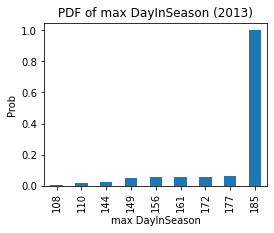

In [74]:
plt.figure(figsize=(4,3))
(gb_2013.DayInSeason.max().value_counts().sort_index() / 1014).cumsum().plot(kind="bar")
plt.title(r'PDF of max DayInSeason (2013)')
plt.xlabel('max DayInSeason')
plt.ylabel('Prob')
plt.savefig("PDF of max DayInSeason (2013).png", dpi=600)

In [93]:
loc_list = gb_2013.DayInSeason.max()[(gb_2013.DayInSeason.max() == 185)].index.to_list()

In [95]:
new_data = wheat13[wheat13.Location.isin(loc_list)]

In [96]:
new_data.to_pickle('./data/185day_data13.df')

In [52]:
len(wheat13.Location.unique())

1014

In [72]:
gb_agg_2014 = gb_2014.agg({'Date':[('First_Day_in_Season','min')], 'DayInSeason':[('First_Day_in_Season','min'), ('Length_of_Season',lambda x:np.max(x) - np.min(x))]})

In [73]:
los = gb_agg_2013['DayInSeason']['Length_of_Season'].unique()
df_tmp = {}
for tmp_los in los:
    cts = (gb_agg_2013['Date']['First_Day_in_Season']
           [gb_agg_2013['DayInSeason']['Length_of_Season'] == tmp_los].count())
    df_tmp[tmp_los] = cts
df_tmp = pd.Series(df_tmp)
df_tmp.sort_values()

119      1
160      1
137      2
144      2
182      3
177      5
103      5
184      6
64       6
152      6
96       7
0       12
112     23
185    935
dtype: int64

In [74]:
los = gb_agg_2014['DayInSeason']['Length_of_Season'].unique()
for tmp_los in los:
    cts = (gb_agg_2014['Date']['First_Day_in_Season']
           [gb_agg_2014['DayInSeason']['Length_of_Season'] == tmp_los].count())
    print('{:3} {:3}'.format(tmp_los, cts))

185 971
151   2
169  13
152   4
156   1
170   6
 80   6
160  13
144   6
 64  12
128   1


大多数的位置都记录了一季冬小麦生长的185天，而13年有12个位置只记录了1次数据，这部份数据需要深入调查

### 13年的异常

In [75]:
locations = (gb_agg_2013[gb_agg_2013['DayInSeason']['Length_of_Season'] == 0]
             .index.get_level_values('Location').values)
for loc in locations:
    print(wheat13['Longitude'][wheat13['Location'] == loc].count())
    print(wheat13['Date'][wheat13['Location'] == loc])

1
105317   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105318   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105689   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105688   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105224   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105690   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105687   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105226   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105223   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105225   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105222   2014-03-20
Name: Date, dtype: datetime64[ns]
1
105685   2014-03-20
Name: Date, dtype: datetime64[ns]


这12条数据都出现在一季的季中，且都出现在3月20日

### 其他不足185天是什么情况

In [76]:
for tmp_los in los:
    if tmp_los != 185:
        cts = (gb_agg_2013['Date']['First_Day_in_Season']
               [gb_agg_2013['DayInSeason']['Length_of_Season'] == tmp_los].values)
        for ct in cts:
            print('{:3} {:3}'.format(tmp_los, ct))
 

152 2014-01-02T00:00:00.000000000
152 2014-01-02T00:00:00.000000000
152 2014-01-02T00:00:00.000000000
152 2014-01-02T00:00:00.000000000
152 2014-01-02T00:00:00.000000000
152 2014-01-02T00:00:00.000000000
160 2013-12-01T00:00:00.000000000
144 2013-12-28T00:00:00.000000000
144 2013-12-28T00:00:00.000000000
 64 2014-01-13T00:00:00.000000000
 64 2014-01-13T00:00:00.000000000
 64 2014-01-13T00:00:00.000000000
 64 2014-01-13T00:00:00.000000000
 64 2014-01-15T00:00:00.000000000
 64 2014-01-15T00:00:00.000000000


其他不足185天的数据，统计的首日不是‘2014-11-30’，推测不同位置一季小麦的成熟周期有所不同，导致了不同的位置一季小麦的耕种周期不同

## 找出不同位置小麦耕种的起始结束

In [77]:
dis_2013 = wheat13['DayInSeason'].unique()
print(len(dis_2013), max(dis_2013))
dis_2014 = wheat14['DayInSeason'].unique()
print(len(dis_2014), max(dis_2014))

186 185
186 185


DayInSeason是没有缺失值的，一直从0-185

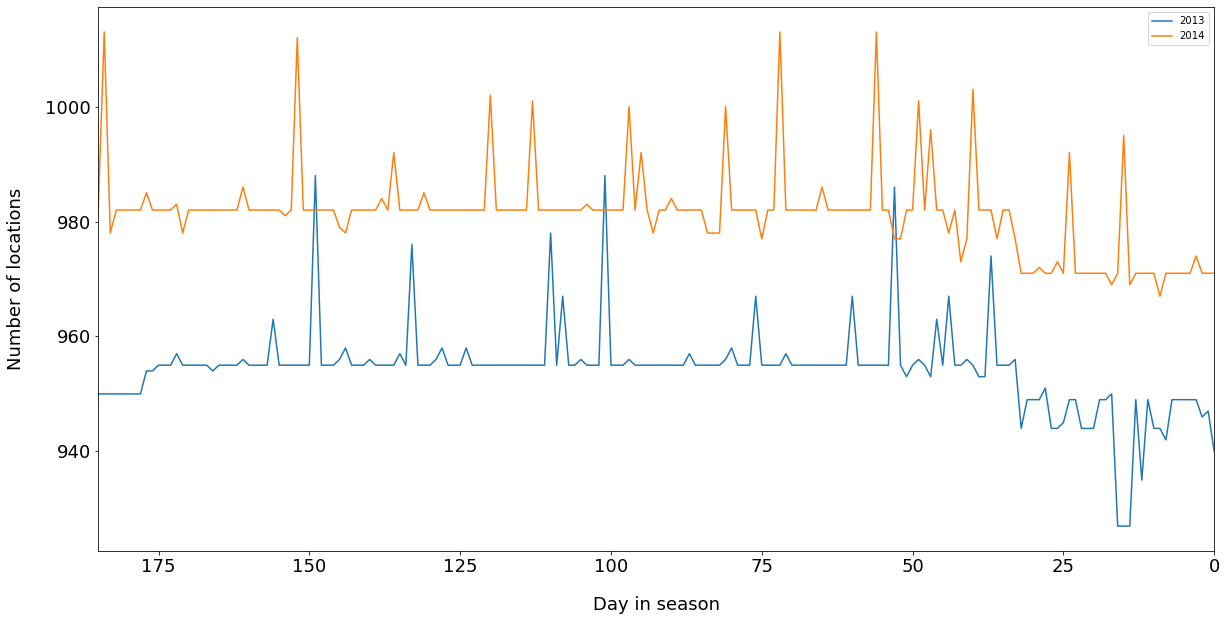

In [78]:
fig, ax = plt.subplots(figsize=(20, 10))


dis_2013.sort()

locs_per_dis = {}
for day in dis_2013:
    locs = wheat13['Location'][wheat13['DayInSeason'] == day].unique()
    locs_per_dis[day] = len(locs)
x = locs_per_dis.keys()
y = locs_per_dis.values()
ax.plot(list(x),list(y), label='2013')


dis_2014.sort()

locs_per_dis = {}
for day in dis_2014:
    locs = wheat14['Location'][wheat14['DayInSeason'] == day].unique()
    locs_per_dis[day] = len(locs)
x = locs_per_dis.keys()
y = locs_per_dis.values()
ax.plot(list(x),list(y), label='2014')



# 图样式
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Number of locations',fontsize=18,labelpad=20 )
ax.yaxis.set_label_position("left")
ax.set_xlim(185,0)
ax.set_xlabel('Day in season',fontsize=18,labelpad=20 )
ax.tick_params(labelsize=18)
plt.legend();


仅根据DayInSeason还不能看出某地何时播种与收获，使用日期

In [79]:
date_2013 = wheat13['Date'].unique()
date_2014 = wheat14['Date'].unique()

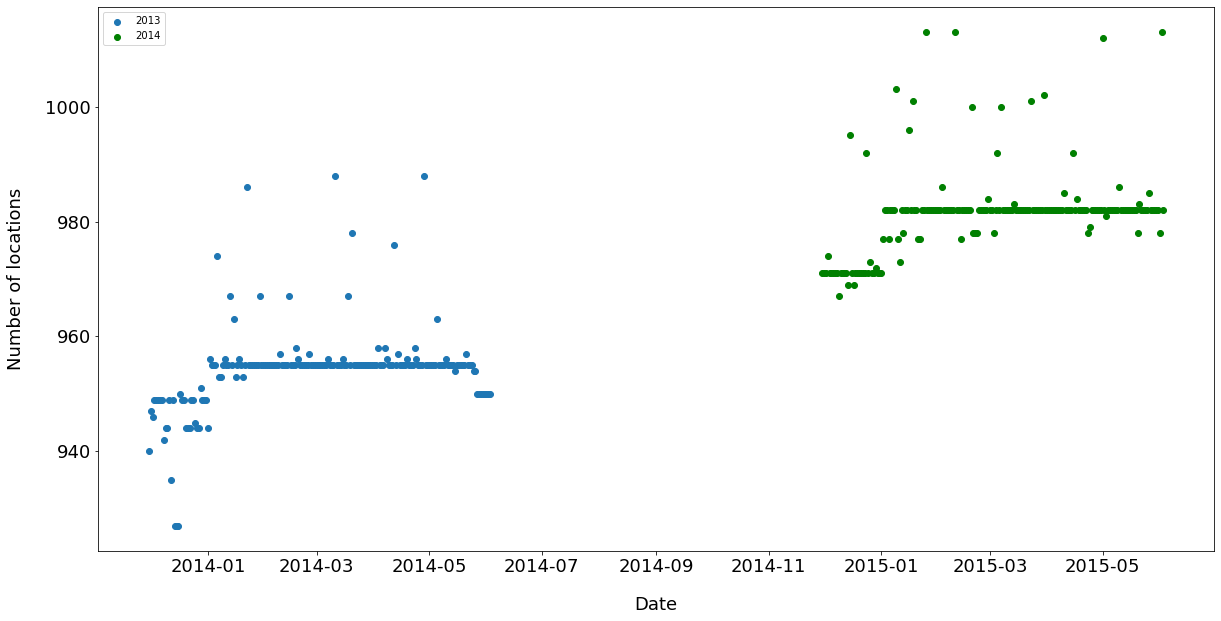

In [73]:
fig, ax = plt.subplots(figsize=(20, 10))

date_2013.sort()

locs_per_date = {}
for day in date_2013:
    locs = wheat13['Location'][wheat13['Date'] == day].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
ax.scatter(list(x),list(y),label='2013')


date_2014.sort()

locs_per_date = {}
for day in date_2014:
    locs = wheat14['Location'][wheat14['Date'] == day].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
ax.scatter(list(x),list(y),color='g',label='2014')


# 图样式
ax.yaxis.set_ticks_position('left')
ax.set_ylabel('Number of locations',fontsize=18,labelpad=20 )
ax.yaxis.set_label_position("left")
ax.set_xlabel('Date',fontsize=18,labelpad=20 )
ax.tick_params(labelsize=18)
plt.legend();

Text(0.5, 0, 'Date')

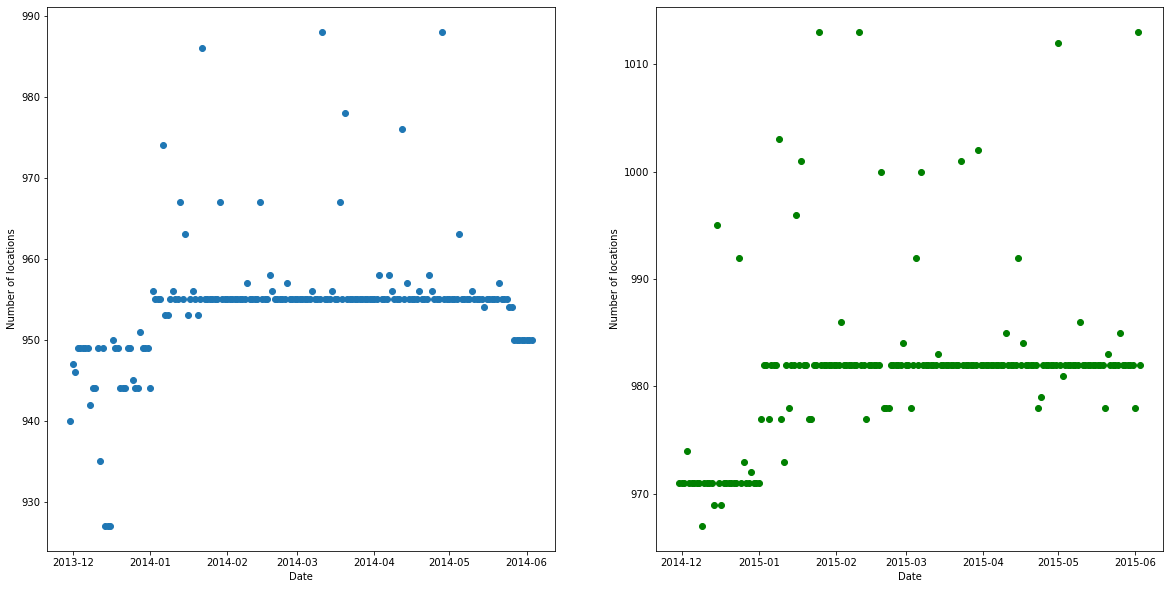

In [90]:
figure = plt.figure(figsize=(20, 10))
fig = plt.subplot(121, )

date_2013.sort()

locs_per_date = {}
for day in date_2013:
    locs = wheat13['Location'][wheat13['Date'] == day].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
fig.scatter(list(x),list(y),label='2013')
fig.yaxis.set_ticks_position('left')
fig.set_ylabel('Number of locations' )
fig.set_xlabel('Date' )


date_2014.sort()

locs_per_date = {}
for day in date_2014:
    locs = wheat14['Location'][wheat14['Date'] == day].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
fig = plt.subplot(122)
fig.scatter(list(x),list(y),color='g',label='2014')
fig.set_ylabel('Number of locations' )
fig.set_xlabel('Date' )


# # 图样式
# ax.yaxis.set_ticks_position('left')
# ax.set_ylabel('Number of locations',fontsize=18,labelpad=20 )
# ax.yaxis.set_label_position("left")
# ax.set_xlabel('Date',fontsize=18,labelpad=20 )
# ax.tick_params(labelsize=18)
# plt.legend();

### 每个地点出现的频率

In [91]:
n_records_2013 = wheat13.groupby(by='Location').agg('count')
n_records_2013.CountyName.value_counts().sort_index(ascending=False)

186    901
185     10
184      2
183     26
178      5
174      3
169      2
153      6
13       2
9        1
8        2
7        4
6        4
5       21
4        6
3        5
2        2
1       12
Name: CountyName, dtype: int64

In [92]:
n_records_2014 = wheat14.groupby(by='Location').agg('count')
n_records_2014.CountyName.value_counts().sort_index(ascending=False)

186    949
185     13
178      3
177      6
154      7
153      4
14       1
13       1
11       3
10       1
9        8
8        4
7        4
6       12
4       13
3        6
Name: CountyName, dtype: int64

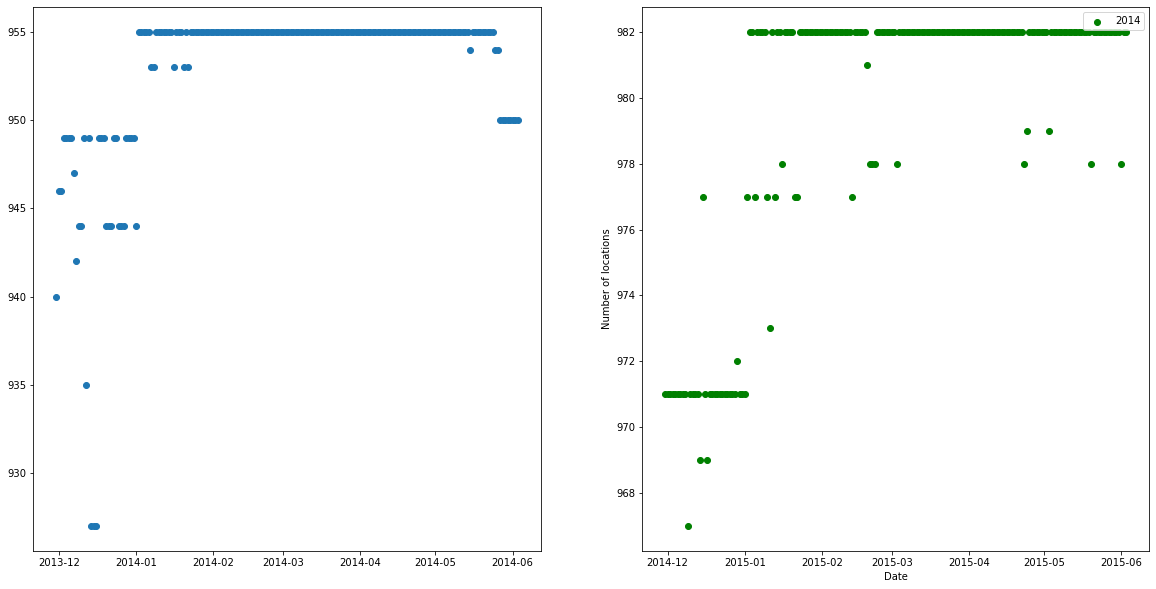

In [95]:
figure = plt.figure(figsize=(20, 10))
fig = plt.subplot(121)


klocs = n_records_2013[n_records_2013.CountyName >= 153].index.get_level_values('Location').values

date_2013.sort()

locs_per_date = {}
for day in date_2013:
    locs = wheat13['Location'][(wheat13['Date'] == day) & (wheat13['Location'].isin(klocs) )].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
fig.scatter(list(x),list(y),label='2013')

klocs = n_records_2014[n_records_2014.CountyName >= 153].index.get_level_values('Location').values

date_2013.sort()

locs_per_date = {}
for day in date_2014:
    locs = wheat14['Location'][(wheat14['Date'] == day) & (wheat14['Location'].isin(klocs) )].unique()
    locs_per_date[day] = len(locs)
x = locs_per_date.keys()
y = locs_per_date.values()
fig = plt.subplot(122)
fig.scatter(list(x),list(y),color='g',label='2014')


# 图样式
fig.yaxis.set_ticks_position('left')
fig.set_ylabel('Number of locations' )
fig.yaxis.set_label_position("left")
fig.set_xlabel('Date' )
plt.legend();





## 删除耕作周期过长或过短的数据

删掉数据中少于13条数据（13年）14条数据（14年），同时删掉耕作周期高于一般水平的地点

In [111]:
counts = n_records_2013.CountyName.value_counts().sort_index(ascending=False).values
levels = n_records_2013.CountyName.value_counts().sort_index(ascending=False).index.values
nrecords = 0
nloc = 0
limit = 153
print('2013:')
for x in np.arange(len(counts)):
    if levels[x] < limit:
        nrecords += levels[x]*counts[x]
        nloc += counts[x]
print('删除 {} 行 ({:4.2f}%) 来自 {} 个地点 ({:4.2f}%)的数据'
      .format(nrecords,nrecords*100/wheat13.shape[0],
              nloc, nloc*100/len(wheat13['Location'].unique())))

2013:
删除 263 行 (0.15%) 来自 59 个地点 (5.82%)的数据


In [112]:
counts = n_records_2014.CountyName.value_counts().sort_index(ascending=False).values
levels = n_records_2014.CountyName.value_counts().sort_index(ascending=False).index.values
nrecords = 0
nloc = 0
limit = 153
print('2014:')
for x in np.arange(len(counts)):
    if levels[x] < limit:
        nrecords += levels[x]*counts[x]
        nloc += counts[x]
print('删除 {} 行 ({:4.2f}%) 来自 {} 个地点 ({:4.2f}%)的数据'
      .format(nrecords,nrecords*100/wheat13.shape[0],
              nloc, nloc*100/len(wheat14['Location'].unique())))

2014:
删除 344 行 (0.19%) 来自 53 个地点 (5.12%)的数据


In [122]:
import pickle
pickle.dump(n_records_2014,open('n_records_2014.pickle','wb'),-1) 
pickle.dump(n_records_2013,open('n_records_2013.pickle','wb'),-1) 

In [1]:
import pickle
n_records_2014 = pickle.load(open('n_records_2014.pickle','rb'))
n_records_2013 = pickle.load(open('n_records_2013.pickle','rb'))

### 两年数据位置对比

/Users/jinkin/miniconda3/envs/bishe-env/lib/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  import sys
/Users/jinkin/miniconda3/envs/bishe-env/lib/python3.6/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


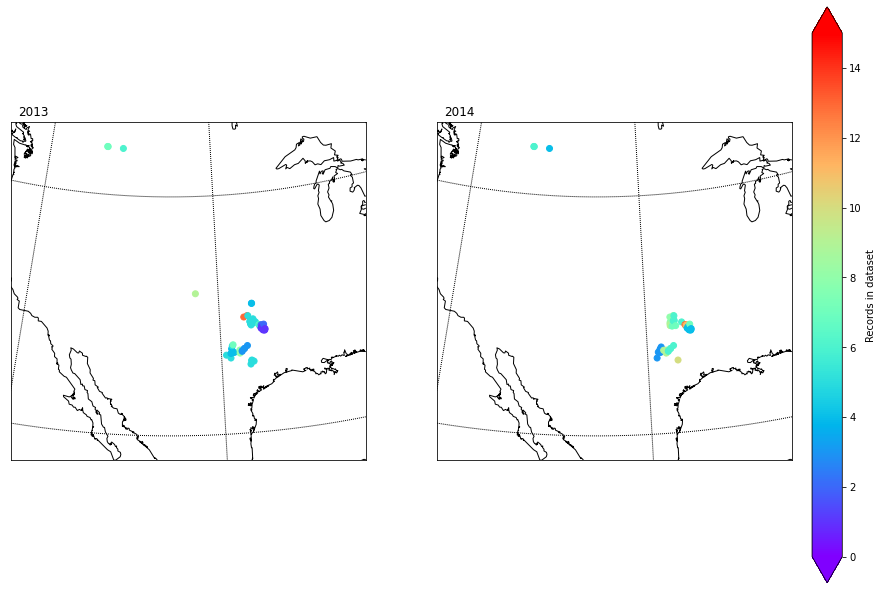

In [7]:
from mpl_toolkits.basemap import Basemap
fig, ax = plt.subplots(1,2,figsize=(14, 20))

mymap = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-80,
                urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
                lon_0=-105, area_thresh=10000,
                resolution = 'l',ax=ax[0])

klocs = n_records_2013[n_records_2013.CountyName < 153].index.get_level_values('Location').values
level = n_records_2013.CountyName[n_records_2013.CountyName < 153].values
# print(locations)
lng = [x[0] for x in klocs]
lat = [x[1] for x in klocs]
yld = level
x,y = mymap(lng, lat)

im1 = mymap.scatter(x, y, c=yld, vmin=0, vmax=15, cmap=mpl.cm.get_cmap('rainbow'), zorder=2)

mymap.drawparallels(np.arange(25,65,20))
mymap.drawmeridians(np.arange(-120,-40,20))
mymap.drawcoastlines()

ax[0].annotate('2013', xy=(0.02, 1.02), fontsize=12,xycoords='axes fraction')

# cax1 = fig.add_axes([0.92, 0.3, 0.03, 0.4])
# cbar = plt.colorbar(im1,cax=cax1, orientation='vertical', extend='both', use_gridspec=True)
# cbar.set_label('Length of Season')

mymap = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-80,
                urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
                lon_0=-105, area_thresh=10000,
                resolution = 'l',ax=ax[1])

klocs = n_records_2014[n_records_2014.CountyName < 153].index.get_level_values('Location').values
level = n_records_2014.CountyName[n_records_2014.CountyName < 153].values

# print(locations)
lng = [x[0] for x in klocs]
lat = [x[1] for x in klocs]
yld = level
x,y = mymap(lng, lat)

im2 = mymap.scatter(x, y, c=yld, vmin=0, vmax=15, cmap=mpl.cm.get_cmap('rainbow'), zorder=2)

mymap.drawparallels(np.arange(25,65,20))
mymap.drawmeridians(np.arange(-120,-40,20))
mymap.drawcoastlines()

ax[1].annotate('2014', xy=(0.02, 1.02), fontsize=12,xycoords='axes fraction')

cax1 = fig.add_axes( [0.92, 0.3, 0.03, 0.4])
cbar = plt.colorbar(im1,cax=cax1, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label('Records in dataset')

两年中，虽然具体位置相同的不多，但是数据仍然分布在相近的位置，气候差距不会太大

## 降水量

In [6]:
wheat13['Location'] = list(zip(wheat13['Longitude'], wheat13['Latitude']))
wheat14['Location'] = list(zip(wheat14['Longitude'], wheat14['Latitude']))

In [7]:
# 计算总降水量
wheat13['precipTotal'] = wheat13.groupby(by='Location')['precipAccumulation'].apply(lambda x: x.cumsum())
wheat14['precipTotal'] = wheat14.groupby(by='Location')['precipAccumulation'].apply(lambda x: x.cumsum())

In [10]:
locations = wheat13['Location'].unique()
for idx,loc in enumerate(locations):
    if idx < 5:
        tmp1 = wheat13['precipAccumulation'][wheat13['Location'] == loc].sum()
        tmp2 = wheat13['precipTotal'][wheat13['Location'] == loc].max()
        print(loc, tmp1, tmp2)

(-118.6952372, 46.81168579999999) 9.982 9.982
(-118.35210929999998, 46.9298391) 12.312000000000001 12.312000000000001
(-118.5101603, 47.0068881) 13.75 13.75
(-118.6996774, 47.1623419) 12.934 12.934000000000001
(-118.43405590000002, 47.157512) 16.644 16.644000000000002


In [17]:
# 降水与产量的相关性
wheat13.groupby(by='Location').agg({'precipTotal': np.max, 'Yield': np.max}).corr()

,precipTotal,Yield
precipTotal,1.000000,0.098991
Yield,0.098991,1.000000


In [13]:
# 按县聚合数据后再计算相关性
wheat13.groupby(by='CountyName').agg({'precipTotal': np.mean, 'Yield': np.max}).corr()

,precipTotal,Yield
precipTotal,1.0000,0.1178
Yield,0.1178,1.0000


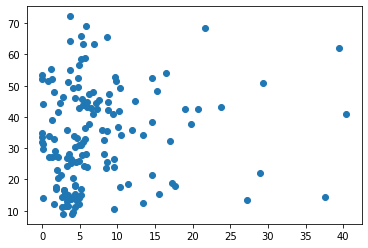

In [16]:
tmp = wheat13.groupby(by='CountyName').agg({'precipTotal': np.mean, 'Yield': np.max})
x = tmp['precipTotal'].values
y = tmp['Yield'].values

plt.scatter(x,y)

## 相关性

In [4]:
# 找出所有的相关性超过0.65的列
X = wheat13.corr()
limit = 0.65
index = X.index.tolist()
n = len(index)
newDF = pd.DataFrame(columns=['col1','col2','corr','corr col1 with target', 'corr col2 with target'])
pos = 0
for nidx,idx in enumerate(index):
    for k in range(n):
        if (k > nidx):
            value = X[idx].iloc[k]
        else:
            value = 0.0
        if value >= limit:
            corr_col1 = X['Yield'].loc[idx]
            corr_col2 = X['Yield'].loc[index[k]]
            newDF.loc[pos] = [idx, index[k] , value, corr_col1, corr_col2]
            pos += 1

In [5]:
newDF.sort_values(by='corr', ascending=False)

,col1,col2,corr,corr col1 with target,corr col2 with target
7,apparentTemperatureMin,temperatureMin,0.992737,-0.049998,-0.060512
2,apparentTemperatureMax,temperatureMax,0.991843,-0.140315,-0.152702
12,precipIntensity,precipIntensityMax,0.912594,0.046476,0.030030
11,dewPoint,temperatureMin,0.910333,0.011607,-0.060512
5,apparentTemperatureMin,dewPoint,0.909563,-0.049998,0.011607
6,apparentTemperatureMin,temperatureMax,0.893452,-0.049998,-0.152702
0,apparentTemperatureMax,apparentTemperatureMin,0.888862,-0.140315,-0.049998
14,temperatureMax,temperatureMin,0.886946,-0.152702,-0.060512
3,apparentTemperatureMax,temperatureMin,0.880383,-0.140315,-0.060512
1,apparentTemperatureMax,dewPoint,0.796342,-0.140315,0.011607


In [6]:
# 找出所有的相关性超过0.65的列
X = wheat14.corr()
limit = 0.65
index = X.index.tolist()
n = len(index)
newDF = pd.DataFrame(columns=['col1','col2','corr','corr col1 with target', 'corr col2 with target'])
pos = 0
for nidx,idx in enumerate(index):
    for k in range(n):
        if (k > nidx):
            value = X[idx].iloc[k]
        else:
            value = 0.0
        if value >= limit:
            corr_col1 = X['Yield'].loc[idx]
            corr_col2 = X['Yield'].loc[index[k]]
            newDF.loc[pos] = [idx, index[k] , value, corr_col1, corr_col2]
            pos += 1

In [7]:
newDF.sort_values(by='corr', ascending=False)

,col1,col2,corr,corr col1 with target,corr col2 with target
2,apparentTemperatureMax,temperatureMax,0.993237,-0.165742,-0.172160
7,apparentTemperatureMin,temperatureMin,0.992886,-0.146381,-0.153430
9,dewPoint,temperatureMin,0.951772,-0.158787,-0.153430
5,apparentTemperatureMin,dewPoint,0.949988,-0.146381,-0.158787
10,precipIntensity,precipIntensityMax,0.863038,-0.015459,-0.020094
0,apparentTemperatureMax,apparentTemperatureMin,0.849104,-0.165742,-0.146381
6,apparentTemperatureMin,temperatureMax,0.844614,-0.146381,-0.172160
3,apparentTemperatureMax,temperatureMin,0.841444,-0.165742,-0.153430
13,temperatureMax,temperatureMin,0.838178,-0.172160,-0.153430
1,apparentTemperatureMax,dewPoint,0.796485,-0.165742,-0.158787


有些特征表现出强相关，如温度相关的属性

### 删除相关性过高的列

删掉一些相关性过高的列，因为其包含的信息在其他的列中已经有所体现

In [9]:
wheat13.drop('precipTypeIsOther', axis=1, inplace=True)
wheat13.drop('apparentTemperatureMin', axis=1, inplace=True)
wheat13.drop('apparentTemperatureMax', axis=1, inplace=True)
wheat13.drop('precipIntensityMax', axis=1, inplace=True)
#
wheat14.drop('precipTypeIsOther', axis=1, inplace=True)
wheat14.drop('apparentTemperatureMin', axis=1, inplace=True)
wheat14.drop('apparentTemperatureMax', axis=1, inplace=True)
wheat14.drop('precipIntensityMax', axis=1, inplace=True)

In [ ]:
wheat13.to_pickle(os.path.join('data','wheat13_clean.df'))
wheat14.to_pickle(os.path.join('data','wheat14_clean.df'))

## 【周报7】地图可视化

In [4]:
# read data 
df_2013 = pd.read_pickle('./data/df_2013_clean.df')
df_2014 = pd.read_pickle('./data/df_2014_clean.df')

In [4]:
import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

%matplotlib inline

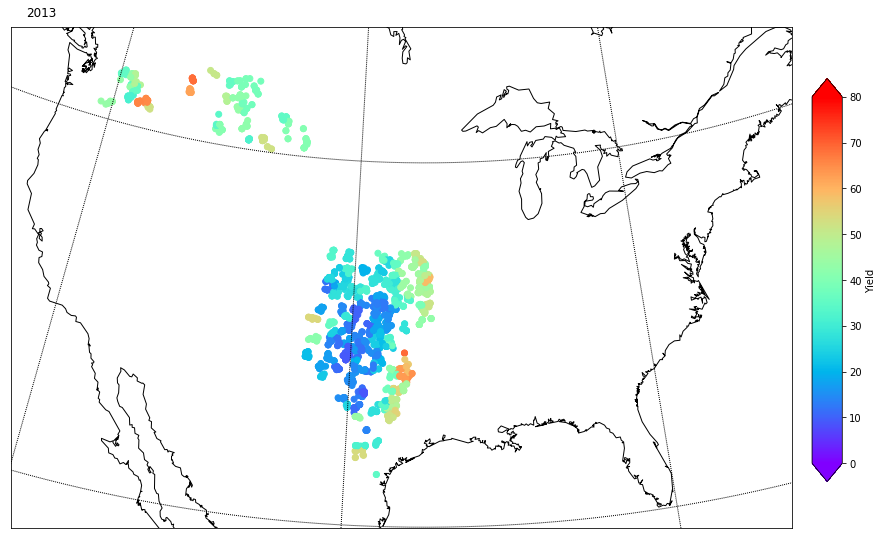

In [7]:
fig, ax = plt.subplots(figsize=(14, 14))

redraw = True
if redraw:
    mymap = Basemap(llcrnrlon=-119, llcrnrlat=22, urcrnrlon=-64,
                    urcrnrlat=49, projection='lcc', lat_1=33, lat_2=45,
                    lon_0=-95, area_thresh=10000,
                    resolution = 'l',)
    pickle.dump(mymap,open('mymap.pickle','wb'),-1)  # pickle it 
else:
    pickle.load(open('mymap.pickle','rb'))


lng = np.array(df_2013[['Longitude']].iloc[::100,:])
lat = np.array(df_2013[['Latitude']].iloc[::100,:])
yld = np.array(df_2013[['Yield']].iloc[::100,:])
x,y = mymap(lng, lat)

im1 = mymap.scatter(x, y, c=yld, vmin=0, vmax=80, cmap=mpl.cm.get_cmap('rainbow'), zorder=2)

mymap.drawparallels(np.arange(25,65,20))
mymap.drawmeridians(np.arange(-120,-40,20))
mymap.drawcoastlines()

ax.annotate('2013', xy=(0.02, 1.02), fontsize=12,xycoords='axes fraction')

cax1 = fig.add_axes([0.92, 0.3, 0.03, 0.4])
cbar = plt.colorbar(im1,cax=cax1, orientation='vertical', extend='both', use_gridspec=True)
cbar.set_label('Yield')


可以看出，这个数据集主要来自两个大地理区域，在下面的这个区域中，偏东的产量要高一些

## 删掉预测无关的列

In [5]:
drop_vec = ['CountyName', 'State', 'Date', 'Location', 'temperatureRatio']
for drop_col in drop_vec:
    if drop_col in df_2013.columns:
        df_2013.drop(drop_col, axis=1, inplace=True)
    if drop_col in df_2014.columns:
        df_2014.drop(drop_col, axis=1, inplace=True)

## 散布矩阵

In [9]:
# 抽100点作散布矩阵
df_tmp = df_2013.sample(n=100)

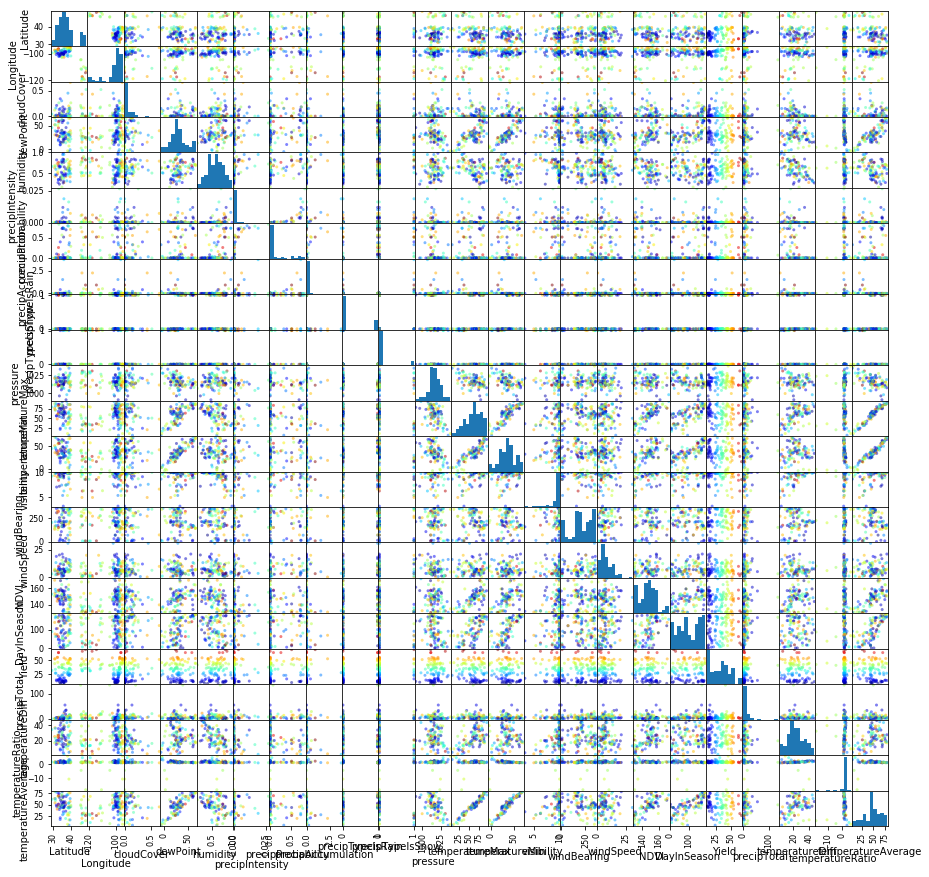

In [11]:
import matplotlib.cm as cm
pd.plotting.scatter_matrix(df_tmp, diagonal='hist', figsize=(15, 15), c=df_tmp["Yield"].tolist(), cmap=cm.get_cmap('jet'));

通过之前的相关性矩阵和上面分布矩阵，可以看出一些数据特征之间有显著的多重共线性

共线性会导致难以分清哪些指标与产量的关系最为强烈，但是对于预测产量来说，共线性的数据也能用，在预测的时候可以使用正规化的手段来减轻共线性特征的影响

## 训练-测试集划分

In [20]:
from sklearn.model_selection import train_test_split
y = df_2013['Yield']
X = df_2013.drop('Yield', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X.drop(['Longitude', 'Latitude'], axis=1), y, test_size=0.2, random_state=42)

## 数值标准化

In [22]:
from sklearn import preprocessing
columns_to_scale = [# 'Latitude',
#     'Longitude',
    'cloudCover',
    'dewPoint',
    'humidity',
    'precipIntensity',
    'precipProbability',
    'precipAccumulation',
#     'precipTypeIsRain,
#     'precipTypeIsSnow,
    'pressure',
    'temperatureMax',
    'temperatureMin',
    'visibility',
    'windBearing',
    'windSpeed',
    'NDVI',
    'DayInSeason',]

std_scaler = preprocessing.StandardScaler().fit(X_train[columns_to_scale])
X_train[columns_to_scale] = std_scaler.transform(X_train[columns_to_scale])


In [23]:
X_test[columns_to_scale] = std_scaler.transform(X_test[columns_to_scale])

## 【周报8】回归模型测试性能

### 算法性能总结

| 算法              | 均方误差     |
|:----------------|:---------|
| 随机森林            | 0.0048   |
| 随机森林10k数据       | 0.1096   |
| KNN             | 60.6555 |
| 多项式回归           | 108.4011 |
| 正规化多项式回归        | 108.4891 |
| 线性回归            | 179.4249 |
| 正规化线性回归         | 179.4339 |
| SVR多项式核函数1k数据   | 188.4630 |
| SVR RBF核函数10k数据 | 193.5149 |
| SVR线性核函数10k数据   | 197.0644 |
| Gradient boost  | 231.4852 |
| KRR             | 333.6586 |


使用sklearn的交叉验证工具，在13年的数据上测试模型的性能，各模型使用sklearn默认参数，测试结果是模型的均方误差

In [24]:
score_all = {}

In [25]:
# sklean 参数设置
from sklearn.model_selection import cross_val_score
cv_k = 5
cv_scoring = 'neg_mean_squared_error'

In [26]:
# 数据是按照县分好了组并且是按照时间顺序排列对，先对数据进行混洗
from sklearn.model_selection import KFold
kf = KFold(n_splits=cv_k, shuffle=True)

In [27]:
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR

### 线性回归

In [28]:
now = time.time()
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['LR'] = scores.mean()

Accuracy: -201.96 (+/- 2.93)
Exec. time:  0.71 s


### L2正规化线性回归

In [29]:
now = time.time()
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['LRR'] = scores.mean()

Accuracy: -201.96 (+/- 2.47)
Exec. time:  0.42 s


### 多项式回归

In [30]:
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.LinearRegression()
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['PR'] = scores.mean()

Accuracy: -174.95 (+/- 1.45)
Exec. time:  9.06 s


### 正规化多项式回归

In [31]:
now = time.time()
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
est = linear_model.Ridge(alpha = 1.0)
scores = cross_val_score(est, X_train_poly, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['PRR'] = scores.mean()

Accuracy: -174.95 (+/- 2.76)
Exec. time:  3.21 s


In [55]:
df_2013.head()

,Latitude,Longitude,cloudCover,dewPoint,humidity,precipIntensity,precipProbability,precipAccumulation,precipTypeIsRain,precipTypeIsSnow,...,temperatureMin,visibility,windBearing,windSpeed,NDVI,DayInSeason,Yield,precipTotal,temperatureDiff,temperatureAverage
0,46.811686,-118.695237,0.00,29.53,0.91,0.0000,0.00,0.000,0,0,...,27.48,2.46,214,1.18,134.110657,0,35.7,0.000,8.22,31.590
1,46.929839,-118.352109,0.00,29.77,0.93,0.0001,0.05,0.000,1,0,...,26.92,2.83,166,1.01,131.506592,0,35.7,0.000,8.18,31.010
2,47.006888,-118.510160,0.00,29.36,0.94,0.0001,0.06,0.020,0,1,...,26.95,2.95,158,1.03,131.472946,0,35.7,0.020,6.43,30.165
3,47.162342,-118.699677,0.91,29.47,0.94,0.0002,0.15,0.036,0,1,...,27.17,2.89,153,1.84,131.288300,0,35.7,0.036,6.02,30.180
4,47.157512,-118.434056,0.91,29.86,0.94,0.0003,0.24,0.000,1,0,...,27.07,2.97,156,1.85,131.288300,0,35.7,0.000,6.78,30.460


###  随机森林回归

In [32]:
# Random forest regression
now = time.time()
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['RFR'] = scores.mean()

Accuracy: -39.6620 (+/- 1.4839)
Exec. time: 24.73 s


In [33]:
# 性能过于优秀，在缩减数据集上再跑一遍和后面的算法进行比较
now = time.time()
est = RandomForestRegressor(n_estimators=10)
scores = cross_val_score(est, X_train_part, y_train_part, cv=10, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['RFR10k'] = scores.mean()

NameError: name 'X_train_part' is not defined

### Gradient boost

In [34]:
now = time.time()
est = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                max_depth=0.3, random_state=0, loss='ls')
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['GBR'] = scores.mean()

Accuracy: -231.4836 (+/- 3.1818)
Exec. time:  1.34 s


### KNN

In [35]:
now = time.time()
n_neighbors = 5
weight = 'uniform' # 'distance'
est = neighbors.KNeighborsRegressor(n_neighbors, weights=weight, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['KNN'] = scores.mean()

Accuracy: -72.77 (+/- 0.99)
Exec. time: 11.55 s


### 支持向量回归

> 支持向量机的拟合时间复杂度是样本数量的两倍以上，这使得SVM很难运用到具有10000个样本以上的数据集——《机器学习实战》

由于目前的数据集对于SVR来说过于庞大（>100k），要应用SVR的话就只有进行抽样以减少数据量。这就导致性能难以和其他使用量全部数据的模型进行比较

#### RBF kernel

In [36]:
# 抽样缩减数据量到10k
idx = np.random.choice(len(X_train), size=10000, replace=False)
X_train_part = X_train.iloc[idx]
y_train_part = y_train.iloc[idx]

In [37]:
now = time.time()
est = SVR(kernel='rbf', C=1, gamma=0.1)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['SVR_RBF_10k'] = scores.mean()

Accuracy: -198.74 (+/- 11.85)
Exec. time: 20.49 s


#### linear kernel

In [38]:
now = time.time()
est = SVR(kernel='linear', C=1)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['SVR_L_10k'] = scores.mean()

Accuracy: -205.44 (+/- 16.69)
Exec. time: 41.31 s


#### polynomial kernel

使用polynomial kernel运行时间比相当的久，5MIN都没有出结果，进一步缩减数据量进行测试

In [39]:
# 进一步缩减到1k
idx = np.random.choice(len(X_train), size=1000, replace=False)
X_train_part = X_train.iloc[idx]
y_train_part = y_train.iloc[idx]
now = time.time()
est = SVR(kernel='poly', C=1e3, degree=2)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['SVR_P_1k'] = scores.mean()

Accuracy: -219.71 (+/- 44.01)
Exec. time:  0.60 s


### KRR（脊核回归）

使用全体数据进行运算会内存不足，依然抽样10k数据进行测试

In [40]:
idx = np.random.choice(len(X_train), size=10000, replace=False)
X_train_part = X_train.iloc[idx]
y_train_part = y_train.iloc[idx]
#
from sklearn.kernel_ridge import KernelRidge
now = time.time()
est = KernelRidge(kernel='rbf', gamma=0.1)
scores = cross_val_score(est, X_train_part, y_train_part, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))
score_all['KRR'] = scores.mean()

Accuracy: -302.72 (+/- 26.91)
Exec. time: 28.65 s


In [41]:
score_all = pd.DataFrame({"score": score_all})

In [42]:
score_all = score_all.sort_values('score', ascending=False)

In [43]:
score_all

,score
RFR,-39.661992
KNN,-72.766281
PRR,-174.950689
PR,-174.954928
SVR_RBF_10k,-198.741082
LR,-201.961673
LRR,-201.964036
SVR_L_10k,-205.437807
SVR_P_1k,-219.710324
GBR,-231.483615


## 【周报9】进一步测试随机森林

随机森林的性能太好了，是不是过拟合了？

输出各个特征在预测中的权值，看看那个特征影响了产量

In [ ]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
feature_names = X_train_rf.columns
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
est.fit(X_train_rf, y_train_rf)

In [ ]:
pd.DataFrame({'feature': feature_names, 'importances': est.feature_importances_}).sort_values('importances', ascending=False)

通过上面的数据结果可以看到'Longitude'和‘Latitude’对预测结果起主要的影响。两者总的贡献达到了90%，显然是由于地理位置加入训练导致了过拟合。

### 去掉位置信息，再次训练

In [ ]:
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
X_train_rf.drop('Longitude', axis=1, inplace=True)
X_train_rf.drop('Latitude', axis=1, inplace=True)
feature_names = X_train_rf.columns
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
scores = cross_val_score(est, X_train_rf, y_train_rf, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

去掉位置信息进行测试后随机森林依然是性能最好的回归算法

In [ ]:
est.fit(X_train_rf, y_train_rf)
pd.DataFrame({'feature': feature_names, 'importances': est.feature_importances_}).sort_values('importances', ascending=False)

## 绘制随机森林学习曲线

In [83]:
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [ ]:


X, y = X_train_rf, y_train_rf


title = "Learning Curve (Random Forest Without Locations)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
plot_learning_curve(est, title, X, y, ylim=(-1, 1.0), cv=kf, n_jobs=4)


plt.show()

## 【周报10】按位置分组

In [60]:
df_2013 = pd.read_pickle('./data/df_2013_clean.df')
df_2014 = pd.read_pickle('./data/df_2014_clean.df')

将所有的数据按位置进行分组，并从中选出种植时长大于153天的数据

In [61]:
df13_loc_agg = df_2013.groupby('Location').agg({'Location': [('count', 'count')]})
df14_loc_agg = df_2014.groupby('Location').agg({'Location': [('count','count')]})

In [62]:
df13_loc_agg['Location']['count'].value_counts().sort_index(ascending=False)
locs = df13_loc_agg[df13_loc_agg['Location']['count'] >= 153].index.get_level_values('Location').values
locs13 = df_2013['Location'][df_2013['Location'].isin(locs)].unique().tolist()

In [63]:
df14_loc_agg['Location']['count'].value_counts().sort_index(ascending=False)
locs = df14_loc_agg[df14_loc_agg['Location']['count'] >= 153].index.get_level_values('Location').values
locs14 = df_2014['Location'][df_2014['Location'].isin(locs)].unique().tolist()

In [64]:
print('13年符合条件的位置数：', len(locs13), '\n', '14年符合条件的位置数：', len(locs14))

13年符合条件的位置数： 955 
 14年符合条件的位置数： 982


In [65]:
def find_30day_extreme(in_df, in_column, in_agg='min'):
    """
    Calculates a rolling window mean. Then determines the min/max/mean 
    value of all the window aggregates.
    Window size: 30 days.
    in_df: input dataframe
    in_column: column to be aggregated
    in_agg: aggregation function for the list of results ('min','max','mean')
    """
    # Pandas 30 day rolling window. Make sure there are at least 10 samples in the window.
    agg_df = in_df[[in_column,'Date']].rolling('30d', on='Date', min_periods=10).mean()
    agg_list = agg_df[in_column]
    if in_agg == 'min':
        return np.min(agg_list)
    if in_agg == 'max':
        return np.max(agg_list)
    if in_agg == 'mean':
        return np.mean(agg_list)

In [66]:
def calculate_features(tmp_df):
    result = []
    # Minimum average temperature in 30-day period
    result.append(find_30day_extreme(tmp_df, 'temperatureAverage', in_agg='min'))
    # Maximum average temperature in 30-day period
    result.append(find_30day_extreme(tmp_df, 'temperatureAverage', in_agg='max'))
    # Minimum NDVI in 30-day period
    tmp1 = find_30day_extreme(tmp_df, 'temperatureAverage', in_agg='min')
    # Maximum NDVI in 30-day period
    tmp2 = find_30day_extreme(tmp_df, 'temperatureAverage', in_agg='max')
    result.append(tmp2/tmp1)
    # Mean temperature difference and variance
    result.append(tmp_df['temperatureDiff'].mean())
    result.append(tmp_df['temperatureDiff'].std())
    # Mean wind speed
    result.append(tmp_df['windSpeed'].mean())
    # Total precipitation
    result.append(tmp_df['precipTotal'].max())
    # Total yield
    result.append(tmp_df['Yield'].max())
    #
    return result

In [67]:
features = ['longitude',
            'latitude',
            'total_precipitation',
            'minMAT30',
            'maxMAT30',
            'ratioMNDVI30',
            'mean_wind_speed',
            'mean_temperature_diff',
            'std_temperature_diff',
            'yield',
           ]

df_2013_new = pd.DataFrame(columns=features)

In [68]:
now = time.time()

for idx,loc in enumerate(locs13):
    tmp_df = df_2013[df_2013['Location'] == loc]
    (min_mean_average_temparature_30days, 
     max_mean_average_temparature_30days,
     ratio_mean_ndvi_30days,
     mean_temperature_diff,
     std_temperature_diff,
     mean_wind_speed,
     total_precipitation,
     total_yield) = calculate_features(tmp_df)
    longitude = loc[0]
    latitude = loc[1]
    observations = {'longitude': longitude, 
        'latitude': latitude,
        'total_precipitation': total_precipitation,
        'minMAT30': min_mean_average_temparature_30days,
        'maxMAT30': max_mean_average_temparature_30days,
        'ratioMNDVI30': ratio_mean_ndvi_30days,
        'mean_wind_speed': mean_wind_speed,
        'mean_temperature_diff': mean_temperature_diff,
        'std_temperature_diff': std_temperature_diff,
        'yield': total_yield,
       }
    df_2013_new.loc[idx] = pd.Series(observations)
        
print('Exec. time: {:5.2f} s'.format(time.time()-now))

Exec. time: 29.25 s


In [69]:
df_2013_new.shape

(955, 10)

In [71]:
df_2014_new = pd.DataFrame(columns=features)

In [72]:
now = time.time()

for idx,loc in enumerate(locs14):
    tmp_df = df_2014[df_2014['Location'] == loc]
    (min_mean_average_temparature_30days, 
     max_mean_average_temparature_30days,
     ratio_mean_ndvi_30days,
     mean_temperature_diff,
     std_temperature_diff,
     mean_wind_speed,
     total_precipitation,
     total_yield) = calculate_features(tmp_df)
    longitude = loc[0]
    latitude = loc[1]
    observations = {'longitude': longitude, 
        'latitude': latitude,
        'total_precipitation': total_precipitation,
        'minMAT30': min_mean_average_temparature_30days,
        'maxMAT30': max_mean_average_temparature_30days,
        'ratioMNDVI30': ratio_mean_ndvi_30days,
        'mean_wind_speed': mean_wind_speed,
        'mean_temperature_diff': mean_temperature_diff,
        'std_temperature_diff': std_temperature_diff,
        'yield': total_yield,
       }
    df_2014_new.loc[idx] = pd.Series(observations)
        
print('Exec. time: {:5.2f} s'.format(time.time()-now))

Exec. time: 29.77 s


In [73]:
df_2014_new.shape

(982, 10)

In [56]:
df_2013_new.to_pickle('./data/df_2013_features.df')
df_2014_new.to_pickle('./data/df_2014_features.df')

NameError: name 'df_2013_new' is not defined

In [ ]:
df_2013_new.head()

## 聚合后再训练

In [57]:
df_2013_new = pd.read_pickle('./data/df_2013_features.df')
df_2014_new = pd.read_pickle('./data/df_2014_features.df')

In [58]:
df_all = pd.concat([df_2013_new, df_2014_new])

In [59]:
df_all.shape

(1937, 10)

In [74]:
from sklearn.model_selection import train_test_split
y = df_all['yield']
X = df_all.drop('yield',axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
from sklearn import preprocessing
columns_to_scale = df_all.columns.tolist()
columns_to_scale = [x for x in columns_to_scale if x != 'yield']
print(columns_to_scale)

std_scaler = preprocessing.StandardScaler().fit(X_train[columns_to_scale])
minmax_scaler = preprocessing.MinMaxScaler().fit(X_train[columns_to_scale])

X_train[columns_to_scale] = std_scaler.transform(X_train[columns_to_scale])

['longitude', 'latitude', 'total_precipitation', 'minMAT30', 'maxMAT30', 'ratioMNDVI30', 'mean_wind_speed', 'mean_temperature_diff', 'std_temperature_diff']


C:\Users\NADPH\miniconda3\envs\bishe-env\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Users\NADPH\miniconda3\envs\bishe-env\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\NADPH\miniconda3\envs\bishe-env\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [76]:
X_test[columns_to_scale] = std_scaler.transform(X_test[columns_to_scale])

C:\Users\NADPH\miniconda3\envs\bishe-env\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\NADPH\miniconda3\envs\bishe-env\lib\site-packages\pandas\core\frame.py:2969: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
C:\Users\NADPH\miniconda3\envs\bishe-env\lib\site-packages\pandas\core\frame.py:2935: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in 

In [77]:
from sklearn.model_selection import cross_val_score
cv_k = 5
cv_scoring = 'neg_mean_squared_error'
cv_scoring = 'r2'

In [78]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=cv_k, shuffle=True)

In [79]:
from sklearn.ensemble import RandomForestRegressor
now = time.time()
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
scores = cross_val_score(est, X_train, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: 0.8357 (+/- 0.0285)
Exec. time:  2.81 s


In [80]:
X_train_nopos = X_train.drop(['longitude', 'latitude'], axis=1)
now = time.time()
est = RandomForestRegressor(n_estimators=10, n_jobs=-1)
scores = cross_val_score(est, X_train_nopos, y_train, cv=kf, scoring=cv_scoring)
print("Accuracy: %0.4f (+/- %0.4f)" % (scores.mean(), scores.std() * 2))
after = time.time()
print('Exec. time: {:5.2f} s'.format(after-now))

Accuracy: 0.7844 (+/- 0.0562)
Exec. time:  0.72 s


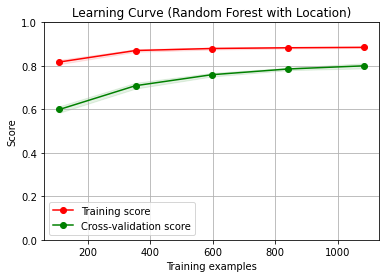

In [84]:
X, y = X_train, y_train
title = "Learning Curve (Random Forest with Location)"
est = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_features= 'sqrt', 
                            min_samples_split=10, min_samples_leaf = 2, max_depth=7 )
plot_learning_curve(est, title, X, y, ylim=(0, 1.0), cv=kf, n_jobs=-1)
plt.show()

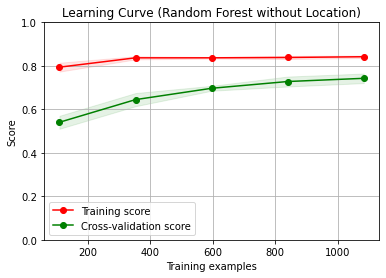

In [85]:
X, y = X_train_nopos, y_train
title = "Learning Curve (Random Forest without Location)"
est = RandomForestRegressor(n_estimators=300, n_jobs=-1, max_features= 'sqrt', 
                            min_samples_split=10, min_samples_leaf = 2, max_depth=7 )
plot_learning_curve(est, title, X, y, ylim=(0, 1.0), cv=kf, n_jobs=-1)
plt.show()

将数据聚合之后，是否包含位置信息影响已经不是很大，差距只有5%